In [1]:
# Import data
import matplotlib.pyplot as plt
import time
import tensorflow as tf
import numpy as np
import scipy.io

import skimage
import skimage.transform
import skimage.io

# User Functions
def yes_no(question):
    answer = 0
    while answer == 0:
        answer_data = input(question)
        if answer_data == 'y' or answer_data == 'n':
            answer = 1
        else:
            print('Try again')
    return answer_data

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 2, 2, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

def weight_variable(name, shape_in):
    return tf.get_variable(name,shape=shape_in, initializer=tf.contrib.layers.xavier_initializer())

def bias_variable(name, shape_in):
    return tf.get_variable(name,shape=shape_in, initializer=tf.contrib.layers.xavier_initializer())


In [2]:
mat_data_train = scipy.io.loadmat('MNIST_data_train_re.mat')
mat_data_test = scipy.io.loadmat('MNIST_data_test_re.mat')

X_train = mat_data_train['X_train']
Y_train = mat_data_train['Y_train']
X_test = mat_data_test['X_test']
Y_test = mat_data_test['Y_test']

del mat_data_train
del mat_data_test

print('training feature\n'+str(np.shape(X_train))+str(np.shape(Y_train))+'\ntraining label\n'+str(np.shape(X_test))+str(np.shape(Y_test)))

training feature
(55000, 112, 112)(55000, 10)
training label
(10000, 112, 112)(10000, 10)


In [3]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

# CNN parameters
input_size_1 = 112
input_size_2 = 112
label_num = 10

num_cell = 512
num_step = 28
num_input = 28

num_fc1 = 256

conv1_output_channel = 128
conv2_output_channel = 256
conv3_output_channel = 512

def LSTM_cell(C_prev, h_prev, x, Wf, bf, Wi, bi, Wc, bc, Wo, bo):
    input_concat = tf.concat([h_prev, x], axis=1)
    ft = tf.sigmoid(tf.matmul(input_concat, Wf) + bf)
    it = tf.sigmoid(tf.matmul(input_concat, Wi) + bi)
    Ct_tilda = tf.tanh(tf.matmul(input_concat, Wc) + bc)
    Ct = tf.multiply(ft, C_prev) + tf.multiply(it, Ct_tilda)
    ot = tf.sigmoid(tf.matmul(input_concat, Wo) + bo)
    ht = tf.multiply(ot, tf.tanh(Ct))
    return Ct, ht

def Attention_model(y, c, W_tanh):
    m = []
    for i in range(len(y)):
        m.append(tf.tanh(tf.matmul(tf.concat([y[i], c], axis=1), W_tanh)))
    m_array = tf.concat([m[i] for i in range(len(y))], axis = 1)
    s = tf.nn.softmax(m_array)
    z = tf.reduce_sum([y[i]*tf.slice(s, begin=[0, i], size=[-1, 1]) for i in range(len(y))], axis = 0)
    return s, z


x = tf.placeholder(tf.float32, shape=[None, input_size_1, input_size_2])
y_ = tf.placeholder(tf.float32, shape=[None, label_num])
lr = tf.placeholder(tf.float64)

batch_num = tf.shape(x)[0]

x_image = tf.reshape(x,[-1, input_size_1, input_size_2, 1])

W_conv1 = weight_variable('W_conv1',[5, 5, 1, conv1_output_channel])
b_conv1 = bias_variable('b_conv1',[conv1_output_channel])

W_conv2 = weight_variable('W_conv2',[5, 5, conv1_output_channel, conv2_output_channel])
b_conv2 = bias_variable('b_conv2',[conv2_output_channel])

W_conv3 = weight_variable('W_conv3',[5, 5, conv2_output_channel, conv3_output_channel])
b_conv3 = bias_variable('b_conv3',[conv3_output_channel])

model_conv_flat = []
model_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
model_conv2 = tf.nn.relu(conv2d(model_conv1, W_conv2) + b_conv2)
model_conv3 = tf.nn.relu(conv2d(model_conv2, W_conv3) + b_conv3)

print(model_conv1.get_shape())
print(model_conv2.get_shape())
print(model_conv3.get_shape())

model_cnn = tf.reshape(model_conv3,[-1,14*14,conv3_output_channel])

print(model_cnn.get_shape())

model_cnn_list = tf.unstack(model_cnn, axis = 1)

print(len(model_cnn_list), model_cnn_list[0].get_shape())

attention_state_num = model_cnn_list[0].get_shape()[1]

attention_input_dim = attention_state_num + num_cell

attention_c_init = tf.zeros([batch_num, num_cell], dtype=tf.float32)

W_tanh1 = weight_variable('W_tanh1', [attention_input_dim, 1])

attention_s1, attention_z1 = Attention_model(model_cnn_list, attention_c_init, W_tanh1)

print(attention_z1.get_shape())

W_out = weight_variable('W_out',[attention_state_num, label_num])
b_out = bias_variable('b_out',[label_num])

logits = tf.matmul(attention_z1, W_out) + b_out    
y_deep = tf.nn.softmax(logits)

cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=logits))
train_step = tf.train.AdamOptimizer(lr).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_deep,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

print('Done') 
    

Instructions for updating:
Use the retry module or similar alternatives.
(?, 56, 56, 128)
(?, 28, 28, 256)
(?, 14, 14, 512)
(?, 196, 512)
196 (?, 512)
(?, 512)
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

Done


In [6]:
load_name = 'model_05'
save_name = 'model_05'

sess.run(tf.global_variables_initializer())

saver = tf.train.Saver()

load_flag = yes_no('Do you want to LOAD the trained variables? [y/n]')
if load_flag == 'y':
    save_path = './save/' + load_name
    saver.restore(sess, save_path)
    train_flag = yes_no('Do you want to TRAIN the data? [y/n]')
else:
    train_flag = 'y'


train_data_num = np.shape(X_train)[0]
m_test = np.shape(X_test)[0]

print(train_data_num,m_test)

batch_size = 128
nb_epoch = 5
# Trainning step
if train_flag == 'y':
    for i in range(nb_epoch):
        order = np.arange(train_data_num)
        np.random.shuffle(order)
        for batch_step in range(int(train_data_num/batch_size)+1):
            batch_idx = [batch_step*batch_size, (batch_step+1)*batch_size]
            if batch_idx[1] > train_data_num: batch_idx[1] = train_data_num
            batch_x = X_train[order[batch_idx[0]:batch_idx[1]],:,:]
            batch_y = Y_train[order[batch_idx[0]:batch_idx[1]],:]
#             print(np.shape(batch_x),np.shape(batch_y))
            train_step.run(feed_dict={x:batch_x, y_: batch_y, lr:0.0001})
            
            print_num = int((batch_step/(int(train_data_num/batch_size)+1))*30)
            print_string = "epoch %d/%d, ["%(i+1,nb_epoch)+"="*print_num+" "*(30-print_num) +"]"
            print(print_string, end="\r")

        batch_idx = np.random.choice(train_data_num,batch_size, replace = False)
        batch_x = X_train[batch_idx,:,:]
        batch_y = Y_train[batch_idx,:]
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_: batch_y})
        cost_value = cross_entropy.eval(feed_dict={x: batch_x, y_: batch_y})
        print("epoch %d/%d, cost= %g, training accuracy= %g"%(i+1, nb_epoch, cost_value, train_accuracy))
        save_path = './save/' + save_name
        saver.save(sess, save_path)

        # TEST accuracy calculation
        sample = batch_size
        temp_accuracy=np.zeros([int(m_test/sample)+1])
        for i in range(int(m_test/sample)+1):
            start = i*sample
            end = (i+1)*sample
            if end > m_test:
                end = m_test
            batch_x = X_test[start:end,:,:]
            batch_y = Y_test[start:end,:]
#             print(np.shape(batch_x),np.shape(batch_y))
            temp_temp = accuracy.eval(feed_dict={x: batch_x, y_: batch_y})
            temp_accuracy[i] = temp_temp * (end - start)
            # print("temp accuracy %g"%temp_temp)
        temp_accuracy = np.sum(temp_accuracy)/m_test
        print("test accuracy %g"%temp_accuracy)

Do you want to LOAD the trained variables? [y/n]y
INFO:tensorflow:Restoring parameters from ./save/model_05
Do you want to TRAIN the data? [y/n]y
55000 10000
epoch 1/5, cost= 0.184787, training accuracy= 0.929688
test accuracy 0.9511
epoch 2/5, cost= 0.25999, training accuracy= 0.914062
test accuracy 0.9517
epoch 3/5, cost= 0.0901713, training accuracy= 0.976562
test accuracy 0.9578
epoch 4/5, cost= 0.0945809, training accuracy= 0.96875
test accuracy 0.9649
epoch 5/5, cost= 0.170205, training accuracy= 0.953125
test accuracy 0.9674



Random data set 7668
Test set label   = [0 0 0 0 0 0 1 0 0 0]
pred probability = [[ 0  0  0  0  0  0 99  0  0  0]]
pred number      = 6


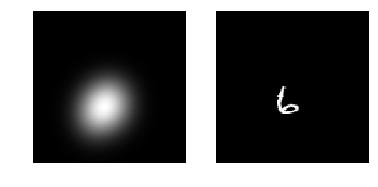

continue? or end? = 

Random data set 7473
Test set label   = [0 0 0 0 1 0 0 0 0 0]
pred probability = [[ 0  4  0  0 65 19  0  0  6  2]]
pred number      = 4


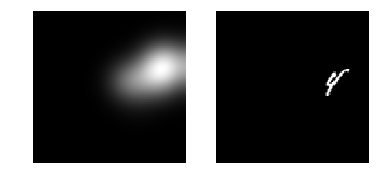

continue? or end? = 

Random data set 2902
Test set label   = [0 1 0 0 0 0 0 0 0 0]
pred probability = [[ 0 99  0  0  0  0  0  0  0  0]]
pred number      = 1


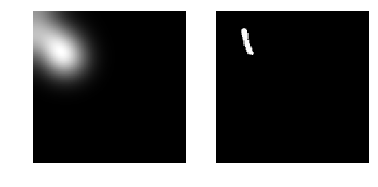

continue? or end? = 

Random data set 2614
Test set label   = [0 0 0 0 0 0 0 0 1 0]
pred probability = [[ 0  0  0  0  0  0  0  0 99  0]]
pred number      = 8


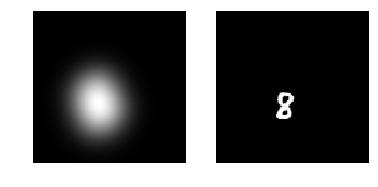

continue? or end? = 

Random data set 9401
Test set label   = [0 1 0 0 0 0 0 0 0 0]
pred probability = [[ 0 99  0  0  0  0  0  0  0  0]]
pred number      = 1


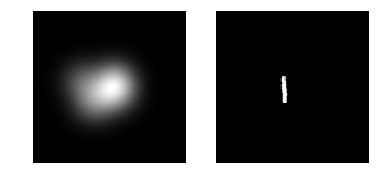

continue? or end? = 

Random data set 1352
Test set label   = [0 0 1 0 0 0 0 0 0 0]
pred probability = [[ 0  0 98  0  0  0  0  0  0  0]]
pred number      = 2


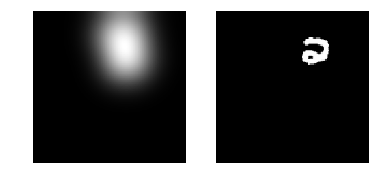

continue? or end? = 

Random data set 8053
Test set label   = [0 0 0 0 0 0 0 0 0 1]
pred probability = [[ 0  0  0  0  0  0  0  0  0 99]]
pred number      = 9


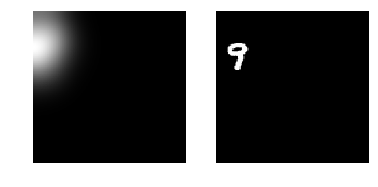

continue? or end? = 

Random data set 8605
Test set label   = [0 0 0 0 0 0 1 0 0 0]
pred probability = [[ 0  0  0  0  0  0 99  0  0  0]]
pred number      = 6


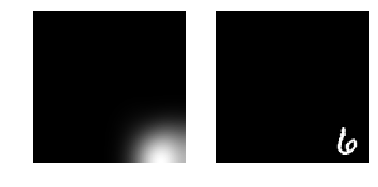

continue? or end? = 

Random data set 1812
Test set label   = [0 0 0 0 0 0 0 0 0 1]
pred probability = [[ 0  0  0  0  1  0  0  0  0 97]]
pred number      = 9


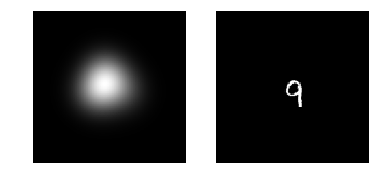

continue? or end? = 

Random data set 7334
Test set label   = [0 0 0 0 0 0 0 1 0 0]
pred probability = [[ 0  0  0  0  0  0  0 99  0  0]]
pred number      = 7


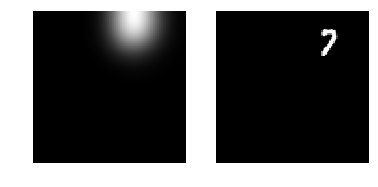

continue? or end? = 

Random data set 6412
Test set label   = [0 0 1 0 0 0 0 0 0 0]
pred probability = [[ 0  0 99  0  0  0  0  0  0  0]]
pred number      = 2


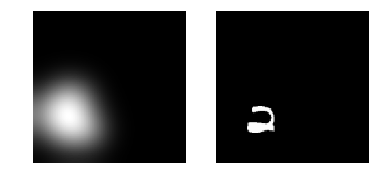

continue? or end? = 

Random data set 6730
Test set label   = [0 0 0 0 0 0 0 1 0 0]
pred probability = [[ 0  0  0  0  0  0  0 99  0  0]]
pred number      = 7


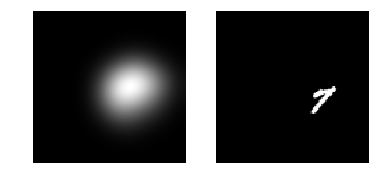

continue? or end? = 

Random data set 9704
Test set label   = [1 0 0 0 0 0 0 0 0 0]
pred probability = [[99  0  0  0  0  0  0  0  0  0]]
pred number      = 0


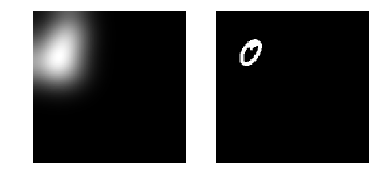

continue? or end? = 

Random data set 6485
Test set label   = [0 0 0 0 0 0 0 0 1 0]
pred probability = [[ 0  0  0  0  0  0  0  0 99  0]]
pred number      = 8


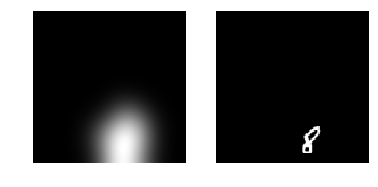

continue? or end? = 

Random data set 964
Test set label   = [0 1 0 0 0 0 0 0 0 0]
pred probability = [[ 0 99  0  0  0  0  0  0  0  0]]
pred number      = 1


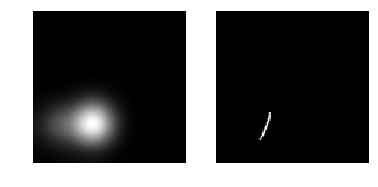

continue? or end? = 

Random data set 1140
Test set label   = [0 0 0 0 1 0 0 0 0 0]
pred probability = [[ 0  0  0  0 99  0  0  0  0  0]]
pred number      = 4


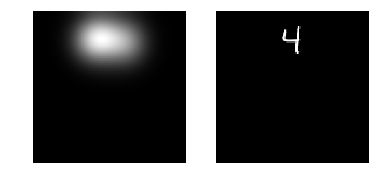

continue? or end? = 

Random data set 7798
Test set label   = [0 0 0 1 0 0 0 0 0 0]
pred probability = [[ 0  0  0 99  0  0  0  0  0  0]]
pred number      = 3


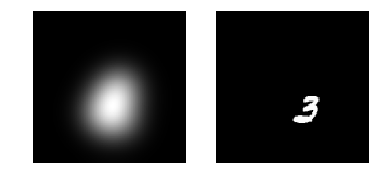

continue? or end? = 

Random data set 2979
Test set label   = [0 0 0 0 0 0 0 0 0 1]
pred probability = [[ 0  0  0  0  1  0  0  0  1 96]]
pred number      = 9


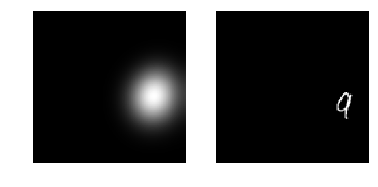

continue? or end? = 

Random data set 8222
Test set label   = [0 0 0 0 1 0 0 0 0 0]
pred probability = [[ 0  0  0  0 99  0  0  0  0  0]]
pred number      = 4


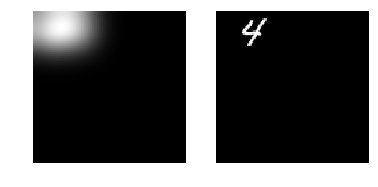

continue? or end? = 

Random data set 224
Test set label   = [0 1 0 0 0 0 0 0 0 0]
pred probability = [[ 0 99  0  0  0  0  0  0  0  0]]
pred number      = 1


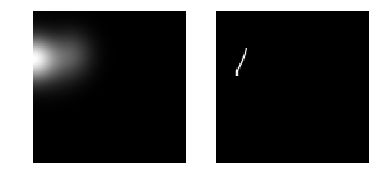

continue? or end? = 

Random data set 8184
Test set label   = [0 0 0 0 0 0 0 0 0 1]
pred probability = [[ 0  0  0  0  0  0  0  0  0 99]]
pred number      = 9


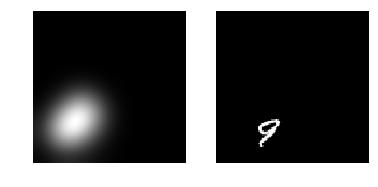

continue? or end? = 

Random data set 351
Test set label   = [0 0 0 0 0 1 0 0 0 0]
pred probability = [[ 0  0  0  0  0 99  0  0  0  0]]
pred number      = 5


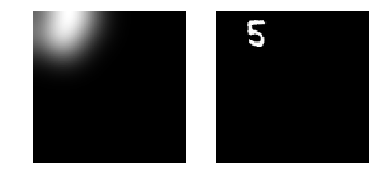

continue? or end? = 

Random data set 9357
Test set label   = [0 0 0 0 0 0 0 0 0 1]
pred probability = [[ 0  0  0  0  0  0  0  3  1 95]]
pred number      = 9


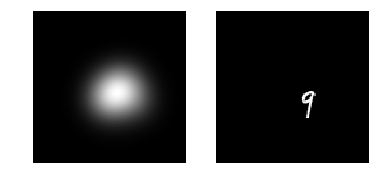

continue? or end? = 

Random data set 4997
Test set label   = [0 0 1 0 0 0 0 0 0 0]
pred probability = [[ 0  0 85  4  0  0  0  0 10  0]]
pred number      = 2


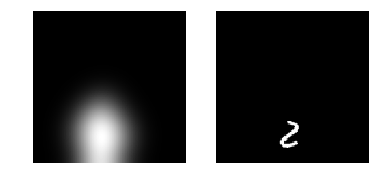

continue? or end? = 

Random data set 7840
Test set label   = [0 0 1 0 0 0 0 0 0 0]
pred probability = [[ 0  0 99  0  0  0  0  0  0  0]]
pred number      = 2


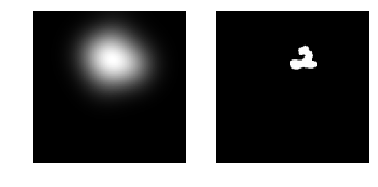

continue? or end? = 

Random data set 4623
Test set label   = [0 0 0 0 0 0 0 1 0 0]
pred probability = [[ 0  0  0  0  0  0  0 99  0  0]]
pred number      = 7


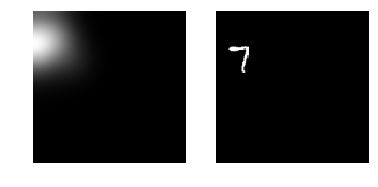

continue? or end? = 

Random data set 3386
Test set label   = [0 1 0 0 0 0 0 0 0 0]
pred probability = [[ 0 99  0  0  0  0  0  0  0  0]]
pred number      = 1


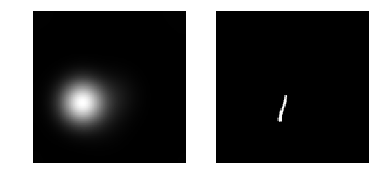

continue? or end? = 

Random data set 809
Test set label   = [0 1 0 0 0 0 0 0 0 0]
pred probability = [[ 0 99  0  0  0  0  0  0  0  0]]
pred number      = 1


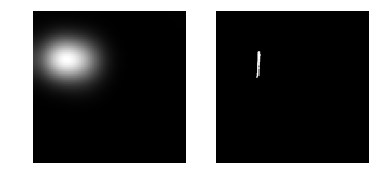

continue? or end? = 

Random data set 1821
Test set label   = [0 0 0 0 0 0 0 0 0 1]
pred probability = [[ 0  0  0  0  0  0  0  1  0 98]]
pred number      = 9


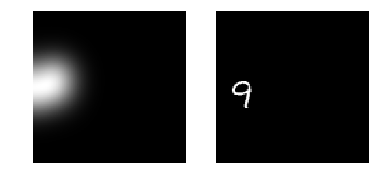

continue? or end? = 

Random data set 2609
Test set label   = [0 0 0 0 0 0 1 0 0 0]
pred probability = [[ 0  0  0  0  0  0 99  0  0  0]]
pred number      = 6


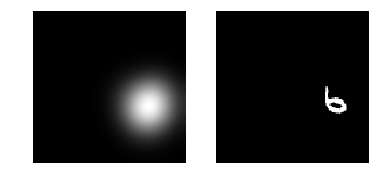

continue? or end? = 

Random data set 6671
Test set label   = [0 0 0 0 0 0 0 0 0 1]
pred probability = [[ 0  0  0  0  0  0  0  0  0 99]]
pred number      = 9


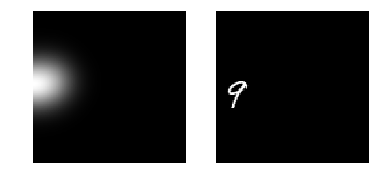

continue? or end? = 

Random data set 6833
Test set label   = [1 0 0 0 0 0 0 0 0 0]
pred probability = [[99  0  0  0  0  0  0  0  0  0]]
pred number      = 0


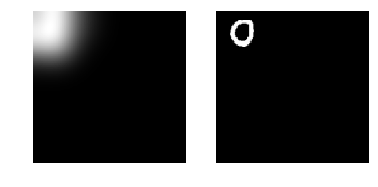

continue? or end? = 

Random data set 6738
Test set label   = [0 0 0 0 1 0 0 0 0 0]
pred probability = [[ 0  0  0  0 99  0  0  0  0  0]]
pred number      = 4


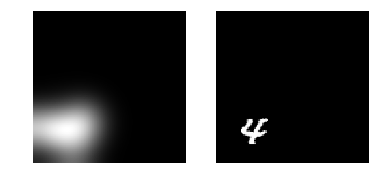

continue? or end? = 

Random data set 6362
Test set label   = [0 0 0 0 1 0 0 0 0 0]
pred probability = [[ 0  0  0  0 99  0  0  0  0  0]]
pred number      = 4


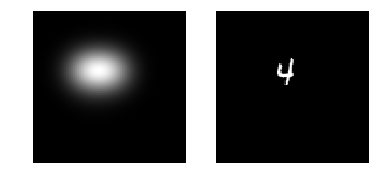

continue? or end? = 

Random data set 7445
Test set label   = [0 0 0 0 0 0 0 1 0 0]
pred probability = [[ 0  0  4  3  0  0  0 90  0  0]]
pred number      = 7


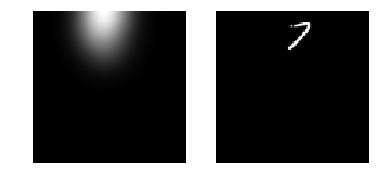

continue? or end? = 

Random data set 9755
Test set label   = [0 0 0 0 0 0 0 0 1 0]
pred probability = [[ 4  0  0  0  0  8  0  0 86  0]]
pred number      = 8


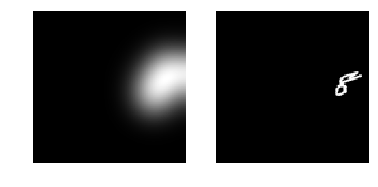

continue? or end? = 

Random data set 9018
Test set label   = [0 0 1 0 0 0 0 0 0 0]
pred probability = [[ 0  0 97  2  0  0  0  0  0  0]]
pred number      = 2


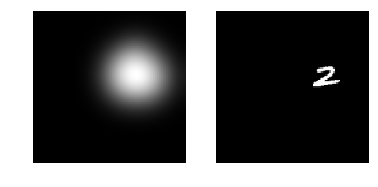

continue? or end? = 

Random data set 7438
Test set label   = [0 0 0 0 0 0 1 0 0 0]
pred probability = [[ 0  0  0  0  0  0 98  0  0  0]]
pred number      = 6


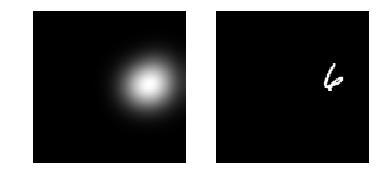

continue? or end? = 

Random data set 151
Test set label   = [0 0 0 0 0 0 0 0 0 1]
pred probability = [[12  0  1 30  0 13  0  0 29 11]]
pred number      = 3


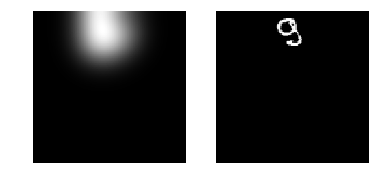

continue? or end? = 

Random data set 492
Test set label   = [0 0 1 0 0 0 0 0 0 0]
pred probability = [[ 0  0 81 14  0  3  0  0  0  0]]
pred number      = 2


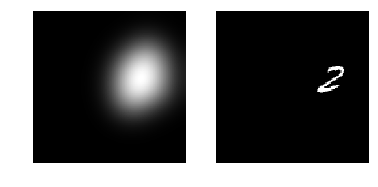

continue? or end? = 

Random data set 4701
Test set label   = [0 0 0 0 0 0 0 0 0 1]
pred probability = [[ 0  0  0  0  0  0  0  0  0 99]]
pred number      = 9


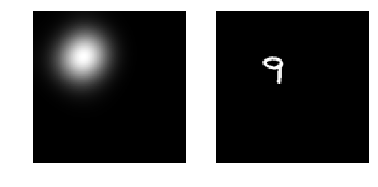

continue? or end? = 

Random data set 4288
Test set label   = [0 0 0 1 0 0 0 0 0 0]
pred probability = [[ 0  0  0 99  0  0  0  0  0  0]]
pred number      = 3


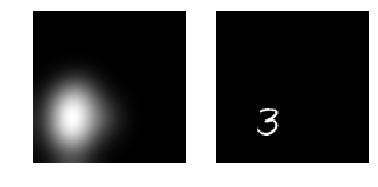

continue? or end? = 

Random data set 7919
Test set label   = [0 0 0 0 0 0 0 0 1 0]
pred probability = [[ 0  0  0  0  0  0  0  0 99  0]]
pred number      = 8


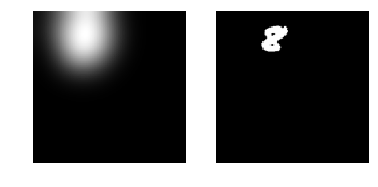

continue? or end? = 

Random data set 6557
Test set label   = [1 0 0 0 0 0 0 0 0 0]
pred probability = [[88  0 10  0  0  0  0  0  0  0]]
pred number      = 0


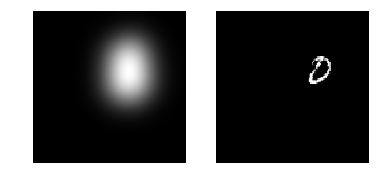

continue? or end? = 

Random data set 5488
Test set label   = [0 0 0 0 0 1 0 0 0 0]
pred probability = [[ 0  0  0  0  0 99  0  0  0  0]]
pred number      = 5


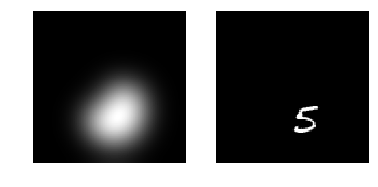

continue? or end? = 

Random data set 587
Test set label   = [0 0 0 0 0 0 1 0 0 0]
pred probability = [[ 0  0  0  0  0  0 99  0  0  0]]
pred number      = 6


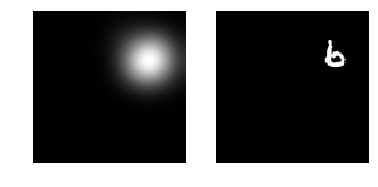

continue? or end? = 

Random data set 3984
Test set label   = [0 0 0 0 0 0 0 0 0 1]
pred probability = [[ 0  0  0  0  0  0  0  3  0 94]]
pred number      = 9


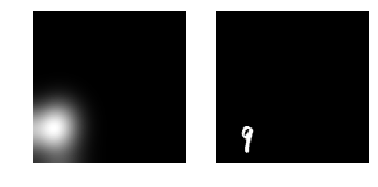

continue? or end? = 

Random data set 7900
Test set label   = [0 1 0 0 0 0 0 0 0 0]
pred probability = [[44 51  0  0  0  0  0  0  3  0]]
pred number      = 1


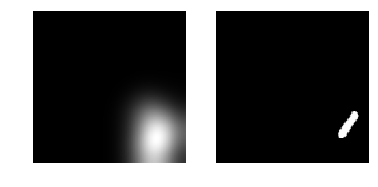

continue? or end? = end


In [7]:
test = 'go'
while test != 'end':
    temp_idx=np.random.randint(1,m_test)
    print('\nRandom data set '+str(temp_idx))
    print('Test set label   = '+str(np.int_(Y_test[temp_idx])))
    y_pre = sess.run(y_deep,feed_dict={x: X_test[temp_idx,:,:].reshape([1,input_size_1,input_size_2])})
    s1_out = sess.run(attention_s1,feed_dict={x: X_test[temp_idx,:,:].reshape([1,input_size_1,input_size_2])})
    s1_image = np.reshape(s1_out,[14, 14])

    print('pred probability = '+str(np.int_(y_pre*100)))
    print('pred number      = '+str(np.argmax(y_pre[0,:])))
    
    heat_map = skimage.transform.pyramid_expand(s1_image, upscale=16, sigma=20)
    
    f1, axarr1 = plt.subplots(1,2)  
    
    
    axarr1[0].imshow(heat_map, cmap='gray')
    axarr1[0].axis("off")
    axarr1[1].imshow(X_test[temp_idx,:,:], cmap='gray')
    axarr1[1].axis("off")
    
    plt.show() 
    
    test = input('continue? or end? = ')
    
